# Chatbot Conversations for Booking Travel
Data and background from: https://datasets.maluuba.com/Frames

Sample dialog in tree viewer: https://codebeautify.org/jsonviewer/cb839c4f


### Libraries and importing the data set

In [1]:
# Libraries

from pandas.io.json import json_normalize
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%pylab inline
from collections import Counter
from textblob import TextBlob
from sklearn import feature_extraction, model_selection, metrics

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Importing json file

with open('frames.json') as datafile:
    data = json.load(datafile)
    
df = pd.DataFrame(json_normalize(data))

### Prepping data: Capturing pertinent information from nested columns

Each dialogue contains a *Turns* column, featuring a nested dictionary of values. These include the text of each turn, what labels these turns contain, and what *acts*, or purpose, these turns are intending to convey. I have had difficulty flattening such a lengthy dictionary, and have instead chosen to pull out the pieces of information I need with for loops.

In [3]:
# Making a new dataframe that takes certain pieces out of Turns

turns, activeFrame, numUsers, numWizard, lilacts, bigacts = ([] for i in range(6))

# For each dialogue (observation) in the original dataframe
for item, frame in df['turns'].iteritems():
# Obtain number of turns per dialogue
    turns.append(len(df['turns'][item]))
# Obtain number of active frames per dialogue
    activeFrame.append(df['turns'][item][(len(df['turns'][item]) - 1)]['labels']['active_frame'])
# Iterating on each turn in an observation/dialogue to get some label info
    for i in range(len(df['turns'][item])):
# Iterating on each label in a Turn
        for j in range(len(df['turns'][item][i]['labels']['acts'])):
# Name of acts in each turn
            lilacts.append((df['turns'][item][i]['labels']['acts'][j]['name']))

    bigacts.append(lilacts)
    lilacts = []

In [4]:
# New dataframe appending the for loops above

results = pd.DataFrame()
results['userRating'] = df['labels.userSurveyRating']
# Wizard Rating is 1 for True, 0 for False now
results['wizardRating'] = df['labels.wizardSurveyTaskSuccessful'].astype(int)
results['numTurns'] = turns
results['numFrames'] = activeFrame
results['acts'] = bigacts
results.head(n=5)

,userRating,wizardRating,numTurns,numFrames,acts
0,4.0,1,7,3,"[inform, inform, no_result, suggest, sorry, in..."
1,3.0,1,20,8,"[inform, inform, greeting, sorry, no_result, i..."
2,2.0,0,21,7,"[inform, inform, greeting, request, inform, re..."
3,5.0,1,13,6,"[inform, inform, greeting, request, inform, re..."
4,5.0,1,9,2,"[inform, inform, greeting, request, inform, in..."


*Acts* (the purposes addressed in each turn of the dialogue) are currently categorical. Acts mentioned per dialogue are stored under *bigacts*. In order to convert the information in *bigacts* to a numerical value, I am appending the following columns:

1. Number of different acts mentioned per dialogue
2. Number of acts per turn in the dialogue
3. 1 if a type of act is utilized in the dialogue, 0 if not.

See below code for act frequencies amongst the entire dataset. *inform* is the most reoccuring act, followed by *no_result*. In the end, because inform is so frequent, I will not append inform to the final dataset.

In [5]:
flat_list = [item for sublist in bigacts for item in sublist]
Counter(flat_list)

Counter({'affirm': 543,
         'canthelp': 61,
         'confirm': 384,
         'goodbye': 229,
         'greeting': 603,
         'hearmore': 100,
         'inform': 10918,
         'moreinfo': 244,
         'negate': 391,
         'no_result': 1218,
         'offer': 4097,
         'reject': 14,
         'request': 3438,
         'request_alts': 216,
         'request_compare': 214,
         'sorry': 756,
         'suggest': 1821,
         'switch_frame': 2102,
         'thankyou': 859,
         'you_are_welcome': 87})

In [5]:
# Lengthy for loop to count what acts occur for each dialogue

uniques, average, inform, noresult, suggest, sorry, negate, thankyou, greeting, switchframe, request, affirm, offer, requestalts, goodbye, requestcompare, moreinfo, confirm, canthelp, hearmore, youarewelcome, reject = ([] for i in range(22))

for item, frame in results['acts'].iteritems():
    uniques.append(len(set(results['acts'][item])))
    average.append((len(results['acts'][item]))/results['numTurns'][item])
    inform.append(results['acts'][item].count('inform') > 0)
    noresult.append(results['acts'][item].count('no_result') > 0)
    suggest.append(results['acts'][item].count('suggest') > 0)
    sorry.append(results['acts'][item].count('sorry') > 0)
    negate.append(results['acts'][item].count('negate') > 0)
    thankyou.append(results['acts'][item].count('thankyou') > 0)
    greeting.append(results['acts'][item].count('greeting') > 0)
    switchframe.append(results['acts'][item].count('switch_frame') > 0)
    request.append(results['acts'][item].count('request') > 0)
    affirm.append(results['acts'][item].count('affirm') > 0)
    offer.append(results['acts'][item].count('offer') > 0)
    requestalts.append(results['acts'][item].count('request_alts') > 0)
    goodbye.append(results['acts'][item].count('goodbye') > 0)
    requestcompare.append(results['acts'][item].count('request_compare') > 0)
    moreinfo.append(results['acts'][item].count('moreinfo') > 0)
    confirm.append(results['acts'][item].count('confirm') > 0)
    canthelp.append(results['acts'][item].count('canthelp') > 0)
    hearmore.append(results['acts'][item].count('hearmore') > 0)
    youarewelcome.append(results['acts'][item].count('you_are_welcome') > 0)
    reject.append(results['acts'][item].count('reject') > 0)
results['acts_unique'] = uniques
results['acts_average'] = average
results['acts_inform'] = inform
results['acts_no_result'] = noresult
results['acts_suggest'] = suggest
results['acts_sorry'] = sorry
results['acts_negate'] = negate
results['acts_thankyou'] = thankyou
results['acts_greeting'] = greeting
results['acts_switch_frame'] = switchframe
results['acts_request'] = request
results['acts_affirm'] = affirm
results['acts_offer'] = offer
results['acts_request_alts'] = requestalts
results['acts_goodbye'] = goodbye
results['acts_request_compare'] = requestcompare
results['acts_moreinfo'] = moreinfo
results['acts_confirm'] = confirm
results['acts_canthelp'] = canthelp
results['acts_hearmore'] = hearmore
results['acts_you_are_welcome'] = youarewelcome
results['acts_reject'] = reject

del results['acts']

In [6]:
# Converting acts from bool to int

results.iloc[:,6::] = results.iloc[:,6::].astype(int)

In [7]:
# Decided to delete the act "inform" from the dataframe, as it is the most commonly occurring act and may overwhelm
# the results.

del results['acts_inform']

### Prepping data: Sentiment Analysis

I'd like to understand the overall sentiment (from the user only) per dialogue. Therefore, the sentiment has been averaged over all of the user's turns per dialogue.

* Polarity on a -1 to 1 scale, where -1 is the most negative and 1 is the most positive.
* Subjectivity on a 0 to 1 scale, where 0 is the most objective and 1 is the most subjective

In [8]:
p_math, s_math, pol, sub = ([] for i in range(4))

for item, frame in df['turns'].iteritems():

# Iterating on each Turn in an observation/dialogue
    for i in range(len(df['turns'][item])):
        if df['turns'][item][i]['author'] == 'user':
            p_math.append(TextBlob(df['turns'][item][i]['text']).sentiment.polarity)
            s_math.append(TextBlob(df['turns'][item][i]['text']).sentiment.subjectivity)
    pol.append(sum(p_math)/len(p_math))
    sub.append(sum(s_math)/len(s_math))
    p_math, s_math = ([] for i in range(2))

results['text_polarity'] = pol
results['text_subjectivity'] = sub

In [9]:
results.head(n=5)

,userRating,wizardRating,numTurns,numFrames,acts_unique,acts_average,acts_no_result,acts_suggest,acts_sorry,acts_negate,...,acts_goodbye,acts_request_compare,acts_moreinfo,acts_confirm,acts_canthelp,acts_hearmore,acts_you_are_welcome,acts_reject,text_polarity,text_subjectivity
0,4.0,1,7,3,6,2.000000,1,1,1,1,...,0,0,0,0,0,0,0,0,-0.060268,0.118304
1,3.0,1,20,8,9,1.600000,1,1,1,1,...,0,0,0,0,0,0,0,0,0.187500,0.327500
2,2.0,0,21,7,11,1.380952,1,1,0,1,...,1,0,0,0,0,0,0,0,0.134091,0.308081
3,5.0,1,13,6,9,1.769231,1,1,0,0,...,0,0,0,0,0,0,0,0,0.095000,0.124286
4,5.0,1,9,2,7,1.777778,0,0,0,0,...,0,1,0,0,0,0,0,0,0.106667,0.273333


### Data Exploration: userSurveyRatings and wizardSurveyTaskSuccessful

There are two labels in this data set:

* *userRating*: How the user rated the dialogue, from 0 (bad) to 5 (good)
* *wizardRating*: How the chatbot rated its ability to solve the user's inquiries, True or False.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x19988cf98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11b197978>], dtype=object)

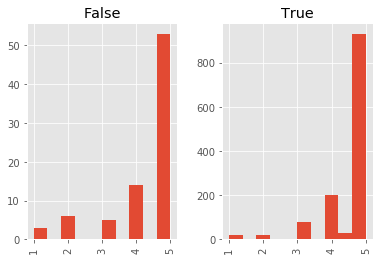

In [319]:
results.hist(column="userRating",by="wizardRating")

### Cleaning the data set and prepping for classification modeling

Most of the dialogues have a label of True for *wizardRating*. To make the model based on only one label, I am removing all *wizardRating* = False points, and then deleting the wizardRating label from the data set.

There were also three rows in which *userRating* was NaN, so these will be dropped as well.

Finally, I will convert *userRating* to int.

In [10]:
cleaned = results[(results['userRating'].notnull()) & (results['wizardRating'] != 0)]
cleaned = cleaned.reset_index()
del cleaned['index']
del cleaned['wizardRating']
cleaned['userRating'] = cleaned.astype(int)

In [11]:
# Creating the feature matrix (X) and target (y)

y = cleaned.iloc[:,0]
X = cleaned.iloc[:,1::]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=33)

### Classification Models: All Features

Running some classification models:

#### Libraries and Pipeline w/ K-Best + SVM

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline


scalar = StandardScaler() #Scaling the features
select = SelectKBest(k=3)
svm_clf = svm.SVC()
#nb_clf = GaussianNB()

steps = [('scalar', scalar),
        ('feature_selection', select),
        ('svm', svm_clf)]

pipeline = Pipeline(steps)

In [18]:
pipeline.fit(X_train, y_train)
pipeline_pred = pipeline.predict(X_test)
print('Test Score: ',metrics.accuracy_score(y_test, pipeline_pred))

Test Score:  0.745341614907


#### Pipeline w/ K-Best + Random Forest Model:

In [19]:
rf_clf = RandomForestClassifier()
steps_rf = [('scalar', scalar),
            ('feature_selection', select),
            ('random_forest', rf_clf)]

pipeline_rf = Pipeline(steps_rf)

pipeline_rf.fit(X_train, y_train)
pipeline_rf_pred = pipeline_rf.predict(X_test)
print('Test Score: ',metrics.accuracy_score(y_test, pipeline_rf_pred))

Test Score:  0.745341614907


#### Pipeline w/ K-Best + Naive Bayes Model:

In [20]:
nb_clf = GaussianNB()
steps_nb = [('scalar', scalar),
            ('feature_selection', select),
            ('naive_bayes', nb_clf)]

pipeline_nb = Pipeline(steps_nb)

pipeline_nb.fit(X_train, y_train)
pipeline_nb_pred = pipeline_nb.predict(X_test)
print('Test Score: ',metrics.accuracy_score(y_test, pipeline_nb_pred))

Test Score:  0.670807453416


### Classification Models: All Features + Tuning to the Random Forest Model

Suspiciously, both SVM and Random Forest produced the same accuracy score of 75% (to several additional significant figures). For this next step, I will use Randomized Search to tune parameters passing into Random Forest.

#### Randomized Search for Random Forest

In [22]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 25),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)
print(random_search.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 9, 'min_samples_split': 9}


In [33]:
rf_tuned_clf = RandomForestClassifier(bootstrap=False, 
                                      criterion='gini', 
                                      max_depth=3, 
                                      max_features=10, 
                                      min_samples_leaf=9, 
                                      min_samples_split=9)

rf_tuned_clf.fit(X_train, y_train)
rf_tuned_clf_pred = rf_tuned_clf.predict(X_test)
print('Test Score: ',metrics.accuracy_score(y_test, rf_tuned_clf_pred))

Test Score:  0.748447204969


The score went up a smidge by just tuning Random Forest, but there's still a lot to be desired.

### Classification Models: Some Features

My assumption are that there are at least 20 different "acts" that show up per dialogue. This many acts, considered as features, may be overwhelming to the models. For the next iteration, I will keep the top 5 acts (not including Inform, which I removed earlier) and rerun the models.

In [115]:
# Reminder of act frequencies
Counter(flat_list)

Counter({'affirm': 543,
         'canthelp': 61,
         'confirm': 384,
         'goodbye': 229,
         'greeting': 603,
         'hearmore': 100,
         'inform': 10918,
         'moreinfo': 244,
         'negate': 391,
         'no_result': 1218,
         'offer': 4097,
         'reject': 14,
         'request': 3438,
         'request_alts': 216,
         'request_compare': 214,
         'sorry': 756,
         'suggest': 1821,
         'switch_frame': 2102,
         'thankyou': 859,
         'you_are_welcome': 87})

In [41]:
# New, cleaned data set with top 5 acts present, excluding inform: offer, request, switch_frame, suggest, no_result

cleaned2 = pd.concat([(cleaned.iloc[:,0:7]), cleaned['acts_switch_frame'], cleaned['acts_request'], 
                     cleaned['acts_offer'], cleaned['text_polarity'], cleaned['text_subjectivity']], axis=1)

# New train and test sets

y2 = cleaned2.iloc[:,0]
X2 = cleaned2.iloc[:,1::]

X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X2, y2, test_size=0.25, random_state=33)

In [44]:
# New randomized search for the new X matrix
param_dist2 = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
random_search2 = RandomizedSearchCV(rf_clf, param_distributions=param_dist2,
                                   n_iter=n_iter_search)

random_search2.fit(X2_train, y2_train)
print(random_search2.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 8}


In [45]:
rf_tuned_clf2 = RandomForestClassifier(bootstrap=False, 
                                      criterion='gini', 
                                      max_depth=3, 
                                      max_features=9, 
                                      min_samples_leaf=8, 
                                      min_samples_split=8)

rf_tuned_clf2.fit(X2_train, y2_train)
rf_tuned_clf2_pred = rf_tuned_clf2.predict(X2_test)
print('Test Score: ',metrics.accuracy_score(y2_test, rf_tuned_clf2_pred))

Test Score:  0.729813664596


This test score is even worse :(

### Classification Models: No Acts

For this last attempt, I am removing acts from the X matrix and just retaining other features, like number of turns and sentiment analysis.

In [50]:
# New, cleaned data set with top 5 acts present, excluding inform: offer, request, switch_frame, suggest, no_result

cleaned3 = pd.concat([(cleaned.iloc[:,0:5]), cleaned['text_polarity'], cleaned['text_subjectivity']], axis=1)

# New train and test sets

y3 = cleaned3.iloc[:,0]
X3 = cleaned3.iloc[:,1::]

X3_train, X3_test, y3_train, y3_test = model_selection.train_test_split(X3, y3, test_size=0.25, random_state=33)

In [51]:
# Randomized search
param_dist3 = {"max_depth": [3, None],
              "max_features": randint(1, 6),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
random_search3 = RandomizedSearchCV(rf_clf, param_distributions=param_dist3,
                                   n_iter=n_iter_search)

random_search3.fit(X3_train, y3_train)
print(random_search3.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 9}


In [52]:
rf_tuned_clf3 = RandomForestClassifier(bootstrap=False, 
                                      criterion='gini', 
                                      max_depth=3, 
                                      max_features=1, 
                                      min_samples_leaf=4, 
                                      min_samples_split=9)

rf_tuned_clf3.fit(X3_train, y3_train)
rf_tuned_clf3_pred = rf_tuned_clf3.predict(X3_test)
print('Test Score: ',metrics.accuracy_score(y3_test, rf_tuned_clf3_pred))

Test Score:  0.745341614907


¯\_(ツ)_/¯